In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore') 
import os
import keras
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import BytesIO
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from concurrent.futures import ThreadPoolExecutor
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Model, Sequential
from keras.applications import EfficientNetV2M
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, Conv2D, Multiply, Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.losses import BinaryCrossentropy
from keras.utils import Sequence
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# Loading the Data

In [2]:
def load_data(undersample_strat=0.07):
    """
    Returns the metadata and image generators for training and validation
    
    :param undersample_strat: the desired proportion of cancerous to non-cancerous lesions in the dataset
    """
    # Extract zipped data to a local directory, if not done already
    if not os.path.isdir('Data'):
        with zipfile.ZipFile('anon-patient-data.zip', 'r') as zip_ref:
            zip_ref.extractall('Data')
        
    # Load the metadata
    skin_cancer_df = pd.read_csv('Data/train-metadata.csv', low_memory=False, usecols=[num for num in range(0, 43) if num not in [2, 7]], index_col='isic_id')
        
    # Randomly undersample the cancer-free lesions in the dataset to enhance performance time and address class imbalance
    rus = RandomUnderSampler(random_state=42, sampling_strategy=undersample_strat)
    (skin_cancer_df, targets) = rus.fit_resample(skin_cancer_df.drop('target', axis=1), skin_cancer_df['target'])
    
    # Add an image path column and turn targets into binary strings
    skin_cancer_df['image_filepath'] = ['Data/image/' + img_id + '.jpg' for img_id in skin_cancer_df.index]
    skin_cancer_df['target'] = targets.astype(str)
    
    # Initialize ImageDataGenerators for testing and validation
    train_df, val_df = train_test_split(skin_cancer_df, test_size=0.4, stratify=targets, random_state=42)
    print(Counter(val_df['target']))
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create training and validation generators from their respective datasets
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col='image_filepath',
        y_col='target',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=None,
        x_col='image_filepath',
        y_col='target',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False)
    
    # Turn the targets back to integers
    skin_cancer_df['target'] = targets.astype(int)
    
    return skin_cancer_df.drop('image_filepath', axis=1), train_generator, val_generator

def extract_image_features(train_generator, val_generator):
    """
    Trains a ResNet50 model to extract features from images of skin lesions
    
    :param train_generator: stores augmented images for training
    :param val_generator: stores scaled images for validation
    """
    # Load ResNet50 with pre-trained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze lower layers and allow fine-tuning on upper layers
    for layer in base_model.layers[:int(len(base_model.layers) * 0.3)]:
        layer.trainable = False
    
    # Add global pooling and temporary classification layers for fine-tuning
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.04), name='fc1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = Dropout(0.1, name='dropout1')(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.04), name='fc2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Dropout(0.1, name='dropout2')(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.04), name='fc3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Dropout(0.1, name='dropout3')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Initialize loss and callback functions
    #loss = WeightedBinaryCrossentropy(weight_zero=1.0, weight_one=2.0)
    early_stopping = EarlyStopping(monitor='val_recall', patience=8, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_recall', factor=0.1, patience=5, min_lr=0.001)
    
    # Compile and train the model
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', 
                  metrics=[keras.metrics.TruePositives(name='true_positives'), keras.metrics.Recall(name='recall'), 
                           keras.metrics.SpecificityAtSensitivity(sensitivity=0.8, name='specificity_at_sensitivity'), BinaryCrossentropy(name='BinaryCrossentropy')])
    history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping, reduce_lr])

    # Use trained model to extract image features 
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
    train_features = GlobalAveragePooling2D()(base_model.predict(train_generator, verbose=1))
    val_features = GlobalAveragePooling2D()(base_model.predict(val_generator, verbose=1))
    images_features = np.vstack([train_features, val_features])

    return images_features, history, base_model

def plot_history(history, fig_name='training_history'):
    """
    Plots the trianing and validation performance across epochs and various metrics
    
    :param history: a history object from model training
    :param fig_name: name to save the figure under
    """
    # Initialize variables required to plot series of charts
    plt.figure(figsize=(18, 16))
    num_plots = int(len(list(history.history.keys())[:-1]) / 2)
    if num_plots % 2 == 0:
        num_rows = num_plots / 2
    else:
        num_rows = (num_plots + 1) / 2
    all_metrics = list(history.history.keys())[:num_plots]
    
    # Plot training & validation performance for every metrics
    for p in range(num_plots):
        metric = all_metrics[p]
        plt.subplot(num_rows, 2, p + 1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        
    # Save the figure
    plt.savefig(fig_name)

Counter({'0': 2246, '1': 157})
Found 3604 validated image filenames belonging to 2 classes.
Found 2403 validated image filenames belonging to 2 classes.
Epoch 1/20
113/113 [==============================] - 690s 6s/step - loss: 53.5752 - true_positives: 134.0000 - recall: 0.5678 - specificity_at_sensitivity: 0.2334 - BinaryCrossentropy: 0.8829 - val_loss: 52.8805 - val_true_positives: 120.0000 - val_recall: 0.7643 - val_specificity_at_sensitivity: 0.1723 - val_BinaryCrossentropy: 0.7101 - lr: 1.0000e-05
Epoch 2/20
113/113 [==============================] - 679s 6s/step - loss: 52.5087 - true_positives: 143.0000 - recall: 0.6059 - specificity_at_sensitivity: 0.2844 - BinaryCrossentropy: 0.8422 - val_loss: 51.7355 - val_true_positives: 21.0000 - val_recall: 0.1338 - val_specificity_at_sensitivity: 0.1126 - val_BinaryCrossentropy: 0.5844 - lr: 1.0000e-05
Epoch 3/20
113/113 [==============================] - 675s 6s/step - loss: 51.4955 - true_positives: 146.0000 - recall: 0.6186 - specifi

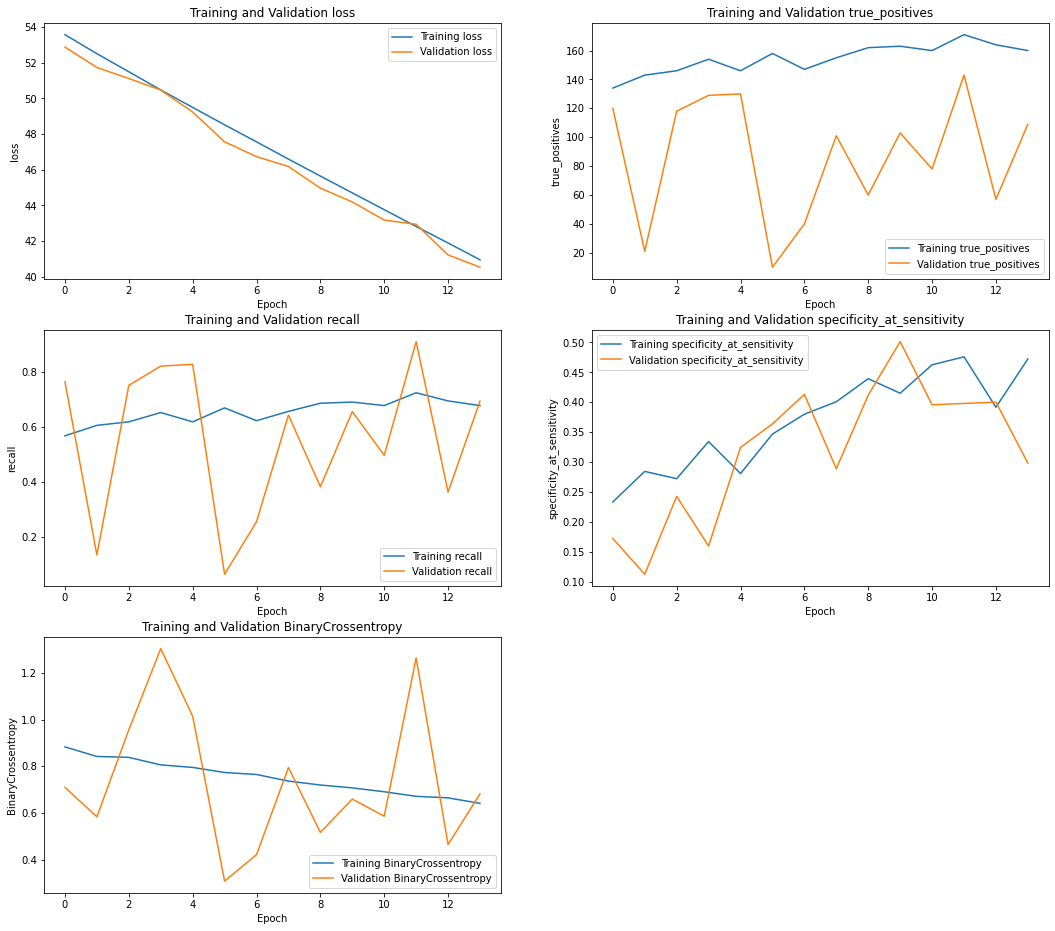

In [3]:
# Load the image features and metadata
skin_cancer_df, train_generator, val_generator = load_data(undersample_strat=0.07)
images_features, resnet_history, feature_extractor = extract_image_features(train_generator, val_generator)
pd.DataFrame(images_features).to_csv('resnet50_features.csv', index=False, header=False)

# Plot and save the loss history
plot_history(resnet_history, 'ResNet50 Performance')

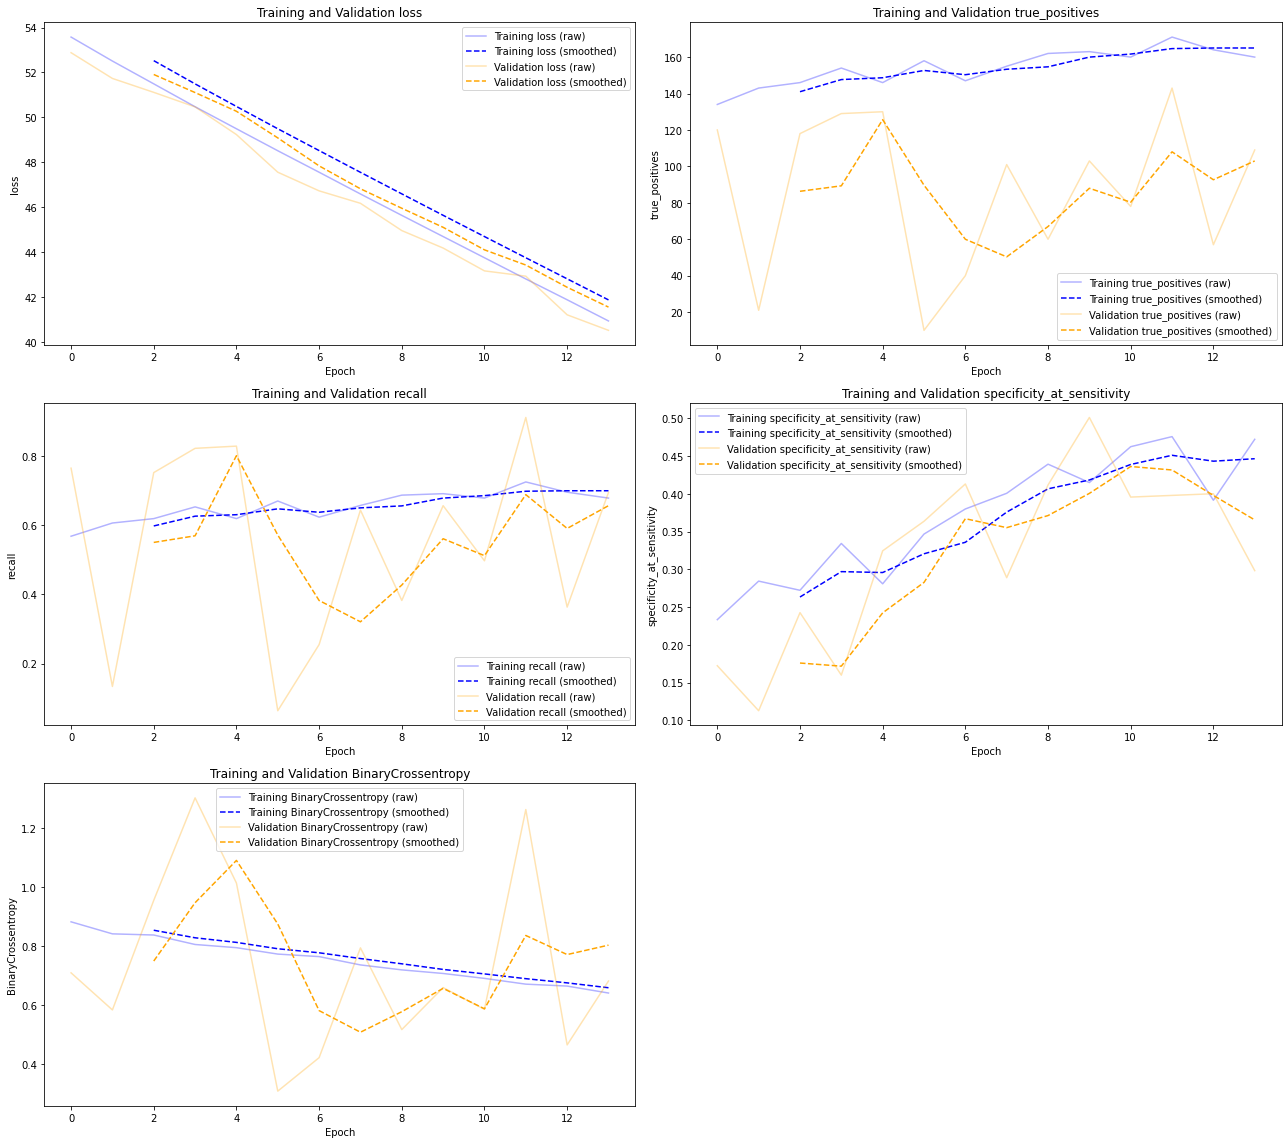

In [4]:
def plot_smoothed_history(history, fig_name='training_history', smooth_factor=3):
    """
    Plots training and validation performance with optional smoothing.
    
    :param history: a history object from model training
    :param fig_name: name to save the figure under
    :param smooth_factor: window size for smoothing metrics
    """
    # Initialize variables required to plot series of charts
    plt.figure(figsize=(18, 16))
    metrics = list(history.history.keys())
    num_plots = len(metrics) // 2  # Training and validation metrics
    
    # Plot training & validation performance for every metric
    for i in range(num_plots):
        metric = metrics[i]
        val_metric = f'val_{metric}'
        
        # Smooth the metrics using rolling average
        train_smooth = pd.Series(history.history[metric]).rolling(smooth_factor).mean()
        val_smooth = pd.Series(history.history[val_metric]).rolling(smooth_factor).mean()
        
        plt.subplot((num_plots + 1) // 2, 2, i + 1)
        plt.plot(history.history[metric], alpha=0.3, label=f'Training {metric} (raw)', color='blue')
        plt.plot(train_smooth, label=f'Training {metric} (smoothed)', color='blue', linestyle='--')
        plt.plot(history.history[val_metric], alpha=0.3, label=f'Validation {metric} (raw)', color='orange')
        plt.plot(val_smooth, label=f'Validation {metric} (smoothed)', color='orange', linestyle='--')
        plt.title(f'Training and Validation {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        
    # Save the figure
    plt.tight_layout()
    plt.savefig(fig_name)

plot_smoothed_history(resnet_history, 'ResNet50 Performance Rolling Average')

# Exploratory Data Analysis of Metadata by Lesion Type (Cancer vs Non-Cancer)

### How balanced is the data?

Out of the 6007 lesions in our dataset, 5614 are not cancerous and 393 are cancerous.


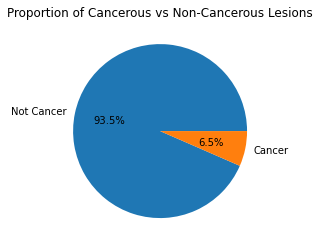

In [6]:
# Report the number of cancerous vs non-cancerous lesions in the data
not_cancer = skin_cancer_df[skin_cancer_df['target'] == 0]
cancer = skin_cancer_df[skin_cancer_df['target'] == 1]
print(f'Out of the {len(skin_cancer_df)} lesions in our dataset, {len(not_cancer)} are not cancerous and {len(cancer)} are cancerous.')

# Visualize the results in a pie chart
fig, ax = plt.subplots()
ax.pie([len(not_cancer), len(cancer)], labels=['Not Cancer', 'Cancer'], autopct='%1.1f%%')
ax.set_title('Proportion of Cancerous vs Non-Cancerous Lesions')
plt.show()

#### The data is heavily imbalanced, with almost all available lesions being non-cancerous. This characteristic of the data is our primary motivator for utilizing anomaly detection rather than binary classification as our method for cancer detection.

### Do men and women make up different proportions of cancerous vs non-cancerous lesions?

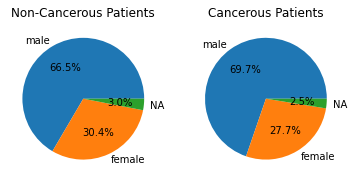

In [7]:
# Obtain the frequencies of each sex for cancerous and non-cancerous lesions
gender_freqs_cancer = Counter(cancer['sex'])
gender_freqs_noncancer = Counter(not_cancer['sex'])

# Visualize the frequencies
fig, ax = plt.subplots(1,2)
ax[0].pie([gender_freqs_noncancer['male'], gender_freqs_noncancer['female'], gender_freqs_noncancer[np.nan]],
       labels=['male', 'female', 'NA'], autopct='%1.1f%%')
ax[0].set_title('Non-Cancerous Patients')
ax[1].pie([gender_freqs_cancer['male'], gender_freqs_cancer['female'], gender_freqs_cancer[np.nan]],
       labels=['male', 'female', 'NA'], autopct='%1.1f%%')
ax[1].set_title('Cancerous Patients')
plt.show()

#### Men are more represented in cancerous lesions than non-cancerous lesions, which aligns with the notion that men are more likely to obtain skin cancer

### Is there a significant difference in the age distribution for cancerous vs non-cancerous patients?

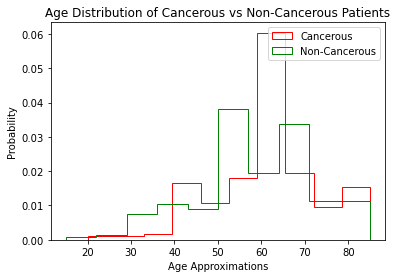

Mann-Whitney U test: U-stat = 960113.5, p-value = 7.450889910682197e-06
There is a significant difference in the age distribution between cancerous and non-cancerous patients.


In [8]:
# Visualize the age distributions
plt.hist(cancer['age_approx'], histtype='step', color='red', density=True, label='Cancerous')
plt.hist(not_cancer['age_approx'], histtype='step', color='green', density=True, label='Non-Cancerous')
plt.legend()
plt.xlabel('Age Approximations')
plt.ylabel('Probability')
plt.title('Age Distribution of Cancerous vs Non-Cancerous Patients')
plt.show()

# Perform the Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(cancer['age_approx'], not_cancer['age_approx'])

# Print the result
print(f'Mann-Whitney U test: U-stat = {u_stat}, p-value = {p_value}')

# Interpretation
if p_value < 0.05:
    print('There is a significant difference in the age distribution between cancerous and non-cancerous patients.')
else:
    print('There is no significant difference in the age distribution between cancerous and non-cancerous patients.')

### Summary Statistics

In [9]:
# Define the columns to compare summary stats for (choose columns that align with the ABCD factors used for skin cancer detection)
use_cols = ['tbp_lv_symm_2axis', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'clin_size_long_diam_mm']

# Present summary statistics for cancerous patients
cancer[use_cols].describe()

,tbp_lv_symm_2axis,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,clin_size_long_diam_mm
count,393.000000,393.000000,393.000000,393.000000
mean,0.317134,20.730862,1.661645,5.749771
std,0.136708,7.329426,1.450894,3.902299
min,0.076033,11.134446,0.000000,1.010000
25%,0.209040,15.303800,0.289490,2.400000
50%,0.303571,18.325280,1.489238,5.140000
75%,0.400000,24.637490,2.505743,7.870000
max,0.767033,49.869050,8.009495,18.940000


In [10]:
# Present summary statistics for non-cancerous patients
not_cancer[use_cols].describe()

,tbp_lv_symm_2axis,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,clin_size_long_diam_mm
count,5614.000000,5614.000000,5614.000000,5614.000000
mean,0.306774,19.117929,1.070067,3.930951
std,0.124023,5.350623,0.747817,1.703545
min,0.083485,11.529400,0.000000,1.040000
25%,0.212894,15.457950,0.579125,2.830000
50%,0.284584,17.512911,0.945596,3.385000
75%,0.380593,21.067609,1.423029,4.380000
max,0.898438,54.097905,6.267660,20.400000


In [11]:
# Use the Mann-Whitney U test to determine if any of these differences are significant
for col in use_cols:
    u_stat, p_value = stats.mannwhitneyu(cancer[col], not_cancer[col])
    if p_value < 0.05:
        print(f'There is a significant difference in {col} between cancerous and non-cancerous patients.')
    else:
        print(f'There is no significant difference in {col} between cancerous and non-cancerous patients.')

There is no significant difference in tbp_lv_symm_2axis between cancerous and non-cancerous patients.
There is a significant difference in tbp_lv_area_perim_ratio between cancerous and non-cancerous patients.
There is a significant difference in tbp_lv_color_std_mean between cancerous and non-cancerous patients.
There is a significant difference in clin_size_long_diam_mm between cancerous and non-cancerous patients.


### Null Values

In [12]:
# Identify columns with null values for non-cancerous patients
not_cancer_nulls = filter(lambda item: item[1] > 0, not_cancer.isnull().sum().items())
print('Columns with null values for non-cancerous patients:')
for tup in not_cancer_nulls:
    print(f'Column: {tup[0]}, No. of Nulls: {tup[1]}, As a %: {round(tup[1]/len(cancer[tup[0]]), 2)}')
    
# Identify columns with null values for cancerous patients
cancer_nulls = filter(lambda item: item[1] > 0, cancer.isnull().sum().items())
print('\nColumns with null values for cancerous patients:')
for tup in cancer_nulls:
    print(f'Column: {tup[0]}, No. of Nulls: {tup[1]}, As a %: {round(tup[1]/len(cancer[tup[0]]), 2)}')

Columns with null values for non-cancerous patients:
Column: age_approx, No. of Nulls: 41, As a %: 0.1
Column: sex, No. of Nulls: 170, As a %: 0.43
Column: anatom_site_general, No. of Nulls: 79, As a %: 0.2

Columns with null values for cancerous patients:
Column: age_approx, No. of Nulls: 3, As a %: 0.01
Column: sex, No. of Nulls: 10, As a %: 0.03


# Data Preprocessing

In [52]:
# Load the metadata
skin_cancer_df = pd.read_csv('Data/train-metadata.csv', low_memory=False, usecols=[num for num in range(0, 43) if num not in [2, 7]], index_col='isic_id')
print(len(skin_cancer_df.columns))
# Randomly undersample the cancer-free lesions in the dataset to enhance performance time
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.07)
(skin_cancer_df, targets) = rus.fit_resample(skin_cancer_df.drop('target', axis=1), skin_cancer_df['target'])
skin_cancer_df['target'] = targets

images_features = pd.read_csv('resnet50_features_best.csv', header=None)

40


In [53]:
# Obtain the categorical (nominal) features
skin_cancer_prepro = skin_cancer_df.copy()
categorical_features = skin_cancer_prepro.select_dtypes(include=['object', 'category', 'string']).columns.tolist()

# Impute and encode values in categorical columns
for feature in categorical_features:
    
    # Impute null values in categorical features with the mode
    skin_cancer_prepro[feature] = skin_cancer_prepro[feature].fillna(skin_cancer_prepro[feature].mode()[0])
    
    # Apply one-hot encoding to categorical (nominal) variables
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_feature = encoder.fit_transform(skin_cancer_prepro[[feature]])
    
    # Add the encoded columns to the dataframe
    encoded_col_names = [f"{feature}_{cat}" for cat in encoder.categories_[0]]
    encoded_feature_df = pd.DataFrame(encoded_feature, columns=encoded_col_names, index=skin_cancer_prepro.index)
    skin_cancer_prepro = pd.concat([skin_cancer_prepro, encoded_feature_df], axis=1)
    
# Remove unencoded categorical columns
skin_cancer_prepro = skin_cancer_prepro.drop(columns=categorical_features)
updated_cols = skin_cancer_prepro.columns
 
# Use KNN to impute null values in the numerical columns
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(skin_cancer_prepro)
skin_cancer_prepro = pd.DataFrame(imputed_array, columns=updated_cols, index=skin_cancer_prepro.index)

# Feature Engineering

In [54]:
def create_features(df):
    """
    Creates new features to help the model evaluate the ABCD factors used by dermatologists
    :param df: a dataframe to add new features to
    :return: the input dataframe with updated features
    """
    og_cols = len(df.columns)
    # A - Asymmetry, Border irregularity/bluriness, and Diameter (skin cancer diameter usually > 6 mm)
    df['diameter_ratio'] = df['tbp_lv_minorAxisMM'] / df['clin_size_long_diam_mm']
    df['area_irregularity'] = np.abs((np.pi * (df['clin_size_long_diam_mm'] / 2)**2) - (df['tbp_lv_areaMM2'])**(1/2))
    df['perimeter_irregularity'] = np.abs((np.pi * df['clin_size_long_diam_mm']) - df['tbp_lv_perimeterMM'])
    df['area_perimeter_ratio'] = df['tbp_lv_areaMM2'] / (df['tbp_lv_perimeterMM'] ** 2)
    df['large_diameter'] = [1 if val > 6 else 0 for val in df['clin_size_long_diam_mm']] # skin cancer diameters tend to be larger than 6 mm
    df['perimeter_to_area'] = (df['tbp_lv_perimeterMM']**2) / df['tbp_lv_areaMM2']
    df['avg_normalized_irregularity'] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"]) / 2
    
    # Color (variation)  
    df['hc_mean_contrast'] = ((df['tbp_lv_H'] + df['tbp_lv_Hext']) / 2) + ((df['tbp_lv_C'] + df['tbp_lv_Cext']) / 2)
    df['tbp_lv_deltaH'] = np.abs(df['tbp_lv_H'] - df['tbp_lv_Hext'])
    df['tbp_lv_deltaC'] = np.abs(df['tbp_lv_C'] + df['tbp_lv_Cext'])
    df['overall_lab_contrast'] = np.sqrt(df['tbp_lv_deltaL']**2 + df['tbp_lv_deltaA']**2 + df['tbp_lv_deltaB']**2)
    df['large_color_variance'] = [1 if val > 4 else 0 for val in df['tbp_lv_color_std_mean']]
    df['average_lab_contrast'] = (df['tbp_lv_deltaL'] + df['tbp_lv_deltaA'] + df['tbp_lv_deltaB']) / 3
    
    # Features to maximize other features
    df['lesion_location'] = np.sqrt(df['tbp_lv_x']**2 + df['tbp_lv_y']**2 + df['tbp_lv_z']**2) # l2 norm of lesion coordinates
    print(f'Created {len(df.columns) - og_cols} New Features During Feature Engineering')
    df = df.drop(['tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'], axis=1)

    return df

# Apply feature engineering
skin_cancer_enhanced = create_features(skin_cancer_prepro.copy())

Created 14 New Features During Feature Engineering


# Feature Importances

In [55]:
# Calculate feature importances using mutual information classification
fs = SelectKBest(score_func=mutual_info_classif, k='all')
skin_cancer_array = fs.fit_transform(skin_cancer_enhanced.drop(['target'], axis=1), skin_cancer_enhanced['target'])

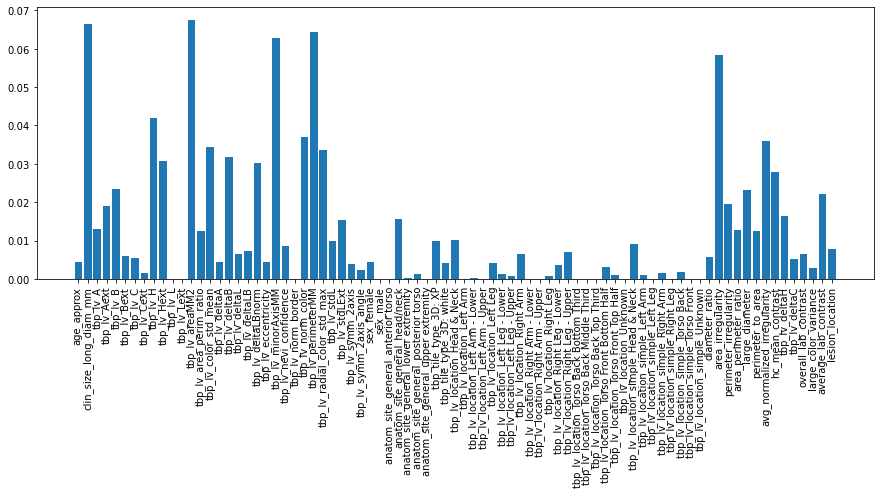

In [56]:
# Plot the feature importances
plt.figure(figsize=(15,5))
use_cols = skin_cancer_enhanced.drop(['target'], axis=1).columns
plt.bar([use_cols[i] for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(rotation='vertical')
plt.show()

# Aggregating Image Features and Metadata

In [57]:
# Combine enhanced metadata and image features into one data set
skin_cancer_full = pd.concat([skin_cancer_enhanced.reset_index(drop=True), images_features], axis=1)
skin_cancer_full.columns = skin_cancer_full.columns.astype(str)

# Isolation Forest

In [58]:
best = (0, 0, 0, None)
cancer = skin_cancer_full[skin_cancer_full['target']==1]
no_cancer = skin_cancer_full[skin_cancer_full['target']==0]
training, val_no_cancer = train_test_split(no_cancer, test_size=0.30, random_state=42)
validation = pd.concat([val_no_cancer, cancer], axis=0)
val_counter = Counter(validation['target'])
print(f'Validation Data: {val_counter[1.0]} cancer, {val_counter[0.0]} not cancer, {round(val_counter[1.0] / val_counter[0.0]*100, 3)}%')

# Scale the data between 0 and 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(training.drop('target', axis=1))
X_test = scaler.transform(validation.drop('target', axis=1))

# Initialize optimal hyperparameters identified during algorithm tuning
c = 50
estimators = 150

# Initialize and train isolation forest
isf = IsolationForest(n_estimators=estimators, contamination=c*0.01, random_state=42)        
scores_prediction = isf.fit(X_train)

# Predict targets for the test data
preds = isf.predict(X_test)
y_preds = [1 if p == -1 else 0 for p in preds]

# Evaluate the models performance on testing data
cr = classification_report(validation['target'], y_preds)
print(cr)

Validation Data: 393 cancer, 1685 not cancer, 23.323%
              precision    recall  f1-score   support

         0.0       0.86      0.51      0.64      1685
         1.0       0.23      0.64      0.34       393

    accuracy                           0.54      2078
   macro avg       0.55      0.58      0.49      2078
weighted avg       0.74      0.54      0.59      2078



# Autoencoder

In [59]:
@keras.saving.register_keras_serializable(name="weighted_bincrossentropy")
class WeightedBinaryCrossentropy(tf.keras.losses.Loss):
    """
    A custom loss functions to address class imbalance
    """
    def __init__(self, weight_zero=1.0, weight_one=2.0, **kwargs):
        super().__init__(**kwargs)
        self.weight_zero = tf.constant(weight_zero, dtype=tf.float32)
        self.weight_one = tf.constant(weight_one, dtype=tf.float32)

    def call(self, y_true, y_pred):
        """
        Returns the weighted binary crossentropy of two lists containing 1s and 0s
        """
        # Ensure shapes and types are compatible
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Compute weighted binary crossentropy
        bin_crossentropy = -(y_true * tf.math.log(y_pred) + (1. - y_true) * tf.math.log(1. - y_pred))
        weights = y_true * self.weight_one + (1. - y_true) * self.weight_zero
        weighted_bin_crossentropy = weights * bin_crossentropy

        return tf.reduce_mean(weighted_bin_crossentropy)

    def get_config(self):
        config = super().get_config()
        config.update({"weight_zero": self.weight_zero.numpy(), "weight_one": self.weight_one.numpy()})
        return config

In [60]:
# Separate data into training and validation - train only on normal data and validate on mixed data
cancer = skin_cancer_full[skin_cancer_full['target'] == 1]
no_cancer = skin_cancer_full[skin_cancer_full['target'] == 0]
training, val_no_cancer = train_test_split(no_cancer, test_size=0.4, random_state=42)
validation = pd.concat([val_no_cancer, cancer], axis=0)

# Scale data between 0 and 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(training.drop('target', axis=1))
X_val = scaler.fit_transform(validation.drop('target', axis=1))
d = 6

# Construct the autoencoder model
autoencoder = Sequential([
    # Encoder
    Dense(1024, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(name='bn1'),
    Dropout(d * 0.1),  
    Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(name='bn2'),
    Dropout(d * 0.1),  
    Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(name='bn3'),
    Dropout(d * 0.1),  
    Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(name='bn4'),

    # Bottleneck
    Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),

    # Decoder
    Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(name='bn5'),
    Dropout(d * 0.1),
    Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(name='bn6'),
    Dropout(d * 0.1),  
    Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    BatchNormalization(name='bn7'),
    Dense(1024, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),

    # Output Layer
    Dense(X_train.shape[1], activation='sigmoid')])

# Compile the model, initialize callback functions, and train on non-cancerous
loss = WeightedBinaryCrossentropy(weight_zero=1.0, weight_one=15.0)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=[loss], metrics = [keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall'), 
                                                                                keras.metrics.TruePositives(name='true_positives'), keras.metrics.AUC(name='auc')])
early_stopping = EarlyStopping(monitor='val_recall', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_recall', factor=0.1, patience=5, min_lr=0.001)
autoencoder_history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Calculate reconstruction error for each sample
reconstructed = autoencoder.predict(X_val)
reconstruction_error = np.mean(np.abs(reconstructed - X_val), axis=1)

# Create predictions for validation set using the optimal threshold that maximizes the distance between TPR and FPR
fpr, tpr, thresholds = roc_curve(validation['target'], reconstruction_error)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
predictions = (reconstruction_error > optimal_threshold).astype(int)
cr = classification_report(validation['target'], predictions)
print(cr)

Epoch 1/100
85/85 [==============================] - 7s 42ms/step - loss: 34.0064 - precision: 0.5746 - recall: 0.2748 - true_positives: 442195.0000 - auc: 0.7292 - val_loss: 28.0544 - val_precision: 0.8887 - val_recall: 0.2201 - val_true_positives: 88596.0000 - val_auc: 0.9011 - lr: 1.0000e-04
Epoch 2/100
85/85 [==============================] - 3s 36ms/step - loss: 23.5405 - precision: 0.8961 - recall: 0.2322 - true_positives: 373618.0000 - auc: 0.9303 - val_loss: 19.6668 - val_precision: 0.8872 - val_recall: 0.2169 - val_true_positives: 87288.0000 - val_auc: 0.9669 - lr: 1.0000e-04
Epoch 3/100
85/85 [==============================] - 3s 36ms/step - loss: 16.7138 - precision: 0.8963 - recall: 0.2293 - true_positives: 368939.0000 - auc: 0.9667 - val_loss: 14.0491 - val_precision: 0.8926 - val_recall: 0.2159 - val_true_positives: 86884.0000 - val_auc: 0.9783 - lr: 1.0000e-04
Epoch 4/100
85/85 [==============================] - 3s 35ms/step - loss: 12.0820 - precision: 0.8966 - recall: 

## Autoencoder Performance

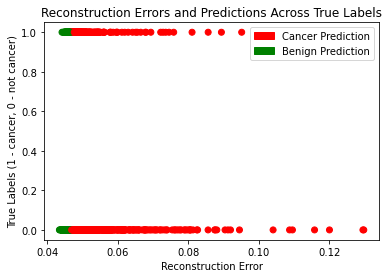

In [61]:
# Plot the autoencoder predictions against the true values
plt.figure()
colors = ['red' if p == 1.0 else 'green' for p in predictions]
plt.title('Reconstruction Errors and Predictions Across True Labels')
plt.scatter(reconstruction_error, validation['target'], color=colors)
plt.xlabel('Reconstruction Error')
plt.ylabel('True Labels (1 - cancer, 0 - not cancer)')
red_patch = mpatches.Patch(color='red', label='Cancer Prediction')
green_patch = mpatches.Patch(color='green', label='Benign Prediction')
plt.legend(handles=[red_patch, green_patch])
plt.savefig('reconstruction errors and predictions across labels' ,bbox_inches='tight')
plt.show()

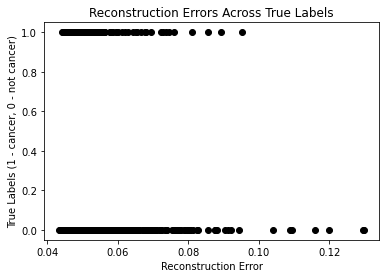

In [62]:
# Plot the autoencoder reconstruction errors against the true values
plt.figure()
plt.title('Reconstruction Errors Across True Labels')
plt.scatter(reconstruction_error, validation['target'], color='black')
plt.xlabel('Reconstruction Error')
plt.ylabel('True Labels (1 - cancer, 0 - not cancer)')
plt.savefig('reconstruction errors for labels' ,bbox_inches='tight')
plt.show()

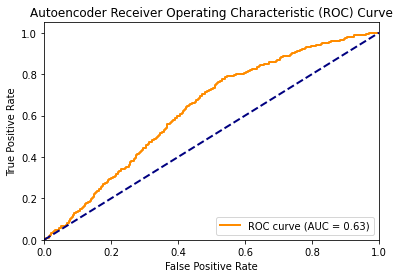

In [63]:
# Compute the ROC curve for the model's predictions
fpr, tpr, thresholds = roc_curve(validation['target'], reconstruction_error)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Autoencoder Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('Autoencoder ROC Curve.png', bbox_inches='tight')
plt.show()

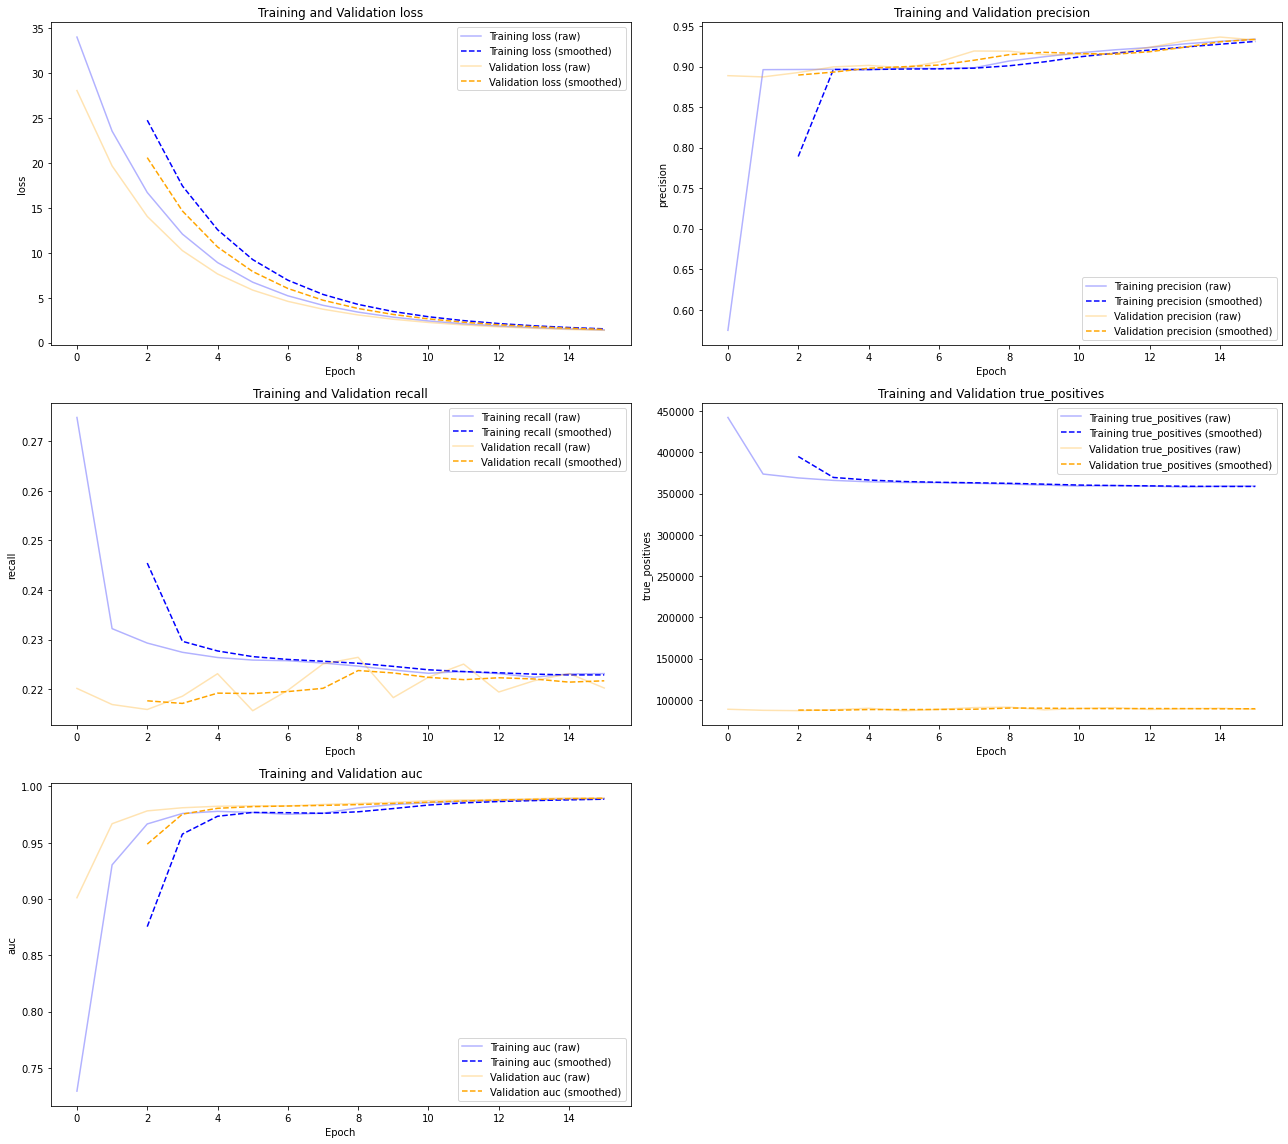

In [64]:
# Plot smoothes autoencoder performance  
plot_smoothed_history(autoencoder_history, 'Autoencoder Performance')

# Simple Binary Classification Models

## Logistic Regression

In [65]:
# Set class weight to balanced to increase sensitivity (recall)
lr = LogisticRegression(random_state=42, max_iter=800, class_weight='balanced')
X_train, X_test, y_train, y_test = train_test_split(skin_cancer_full.drop('target', axis=1), skin_cancer_full['target'], test_size=0.2, 
                                                    stratify=skin_cancer_full['target'], random_state=42)

# Train model and predict test set labels
lr.fit(X_train, y_train)
test_preds = lr.predict(X_test)
test_counter = Counter(y_test)
print(f'Test Data: {test_counter[1.0]} cancer, {test_counter[0.0]} not cancer, {round(test_counter[1.0] / test_counter[0.0]*100, 3)}%')
print('Validation Performance:\n', classification_report(y_test, test_preds))

Test Data: 79 cancer, 1123 not cancer, 7.035%
Validation Performance:
               precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      1123
         1.0       0.28      0.81      0.42        79

    accuracy                           0.85      1202
   macro avg       0.63      0.83      0.66      1202
weighted avg       0.94      0.85      0.88      1202



## CatBoostClassifier

In [66]:
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(random_state=42,class_weights=[1, 2], iterations=1000, verbose=200)

# Split the data
X_train, X_rest, y_train, y_rest = train_test_split(skin_cancer_full.drop('target', axis=1), skin_cancer_full['target'], 
                                                    test_size=0.2, stratify=skin_cancer_full['target'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.05, stratify=y_rest, random_state=42)

# Train the CatBoost model and utilize it for predictions
catboost_model.fit(X_train, y_train)
test_preds = catboost_model.predict(X_test)

# Print test data performance
test_counter = Counter(y_test)
print(f'\nTest Data: {test_counter[1.0]} cancer, {test_counter[0.0]} not cancer, {round(test_counter[1.0] / test_counter[0.0]*100, 3)}%')
print('Test Performance:\n', classification_report(y_test, test_preds))

Learning rate set to 0.020138
0:	learn: 0.6689222	total: 110ms	remaining: 1m 50s
200:	learn: 0.1185283	total: 13.2s	remaining: 52.6s
400:	learn: 0.0685835	total: 26.5s	remaining: 39.6s
600:	learn: 0.0384373	total: 39.9s	remaining: 26.5s
800:	learn: 0.0226914	total: 53.4s	remaining: 13.3s
999:	learn: 0.0145067	total: 1m 6s	remaining: 0us

Test Data: 4 cancer, 57 not cancer, 7.018%
Test Performance:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        57
         1.0       1.00      0.75      0.86         4

    accuracy                           0.98        61
   macro avg       0.99      0.88      0.92        61
weighted avg       0.98      0.98      0.98        61



# Autoencoder and CatBoost Classifier

In [67]:
# Initializwe the catboost model and split the validation reconstruction errors into training and testing
catboost_model = CatBoostClassifier(random_state=42,class_weights=[1, 2], iterations=1000, verbose=200)
X_train, X_test, y_train, y_test = train_test_split(reconstruction_error.reshape(len(reconstruction_error), 1), validation['target'],
                                                    test_size=0.2, stratify=validation['target'], random_state=42)

# Determine the performance of the model on testing reconstruction error data
catboost_model.fit(X_train, y_train)
preds = catboost_model.predict(X_test)
print(classification_report(y_test, preds))

Learning rate set to 0.014174
0:	learn: 0.6883107	total: 1.23ms	remaining: 1.23s
200:	learn: 0.5363296	total: 203ms	remaining: 807ms
400:	learn: 0.5301354	total: 408ms	remaining: 610ms
600:	learn: 0.5229547	total: 615ms	remaining: 408ms
800:	learn: 0.5098457	total: 828ms	remaining: 206ms
999:	learn: 0.4988995	total: 1.04s	remaining: 0us
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91       449
         1.0       0.00      0.00      0.00        79

    accuracy                           0.84       528
   macro avg       0.42      0.50      0.46       528
weighted avg       0.72      0.84      0.78       528



# Conclusion

Binary classification models outperform anomaly detection models. This likely stems from the fact that the success of anomaly detection algorithms requires normal data to look significantly different than anomalies, yet in the real world, cancerous and non-cancerous lesions can often appear identical with very similar features. Doctors frequently attest to this trait of skin lesions, as many admit that some of the lesions they believed to be non-cancerous based off appearance were actually cancerous. Unlike anomaly detection algorithms, many binary classification models do not require there to be stark differences in the appearance of lesions